In [1]:
# Based on https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# and
# https://www.kaggle.com/munna3676/brain-tumor-classification-accuracy-97

# Timothy Isonio
# Finetune a VGG model to classify MRI brain tumor images.
# Outputs to output_dir loss and accuracy curves, and a CSV with the raw data for them

# To use, edit the experiment_name, and {train,test}_data_dir variables in cell 3
# Expects a ImageFolder organized dataset, e.g.
# ./glioma/001.png
# ./glioma/abc.png
# ./meningioma/09090.png

# (i.e. images of any filename in folders corresponding to their labels)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import time
import os
import copy

In [3]:
torch.manual_seed(0)
import random
random.seed(0)
np.random.seed(0)

In [4]:
output_dir = "tumor_cls_results"


#experiment_name = "LR_train_X4"
#train_data_dir = "../Super-Resolution/dataset/BrainTumor/LR_train/X4"
#test_data_dir = "../Super-Resolution/dataset/BrainTumor/LR_test/X4"

# experiment_name = "LR_X3"
# train_data_dir = "../Super-Resolution/dataset/BrainTumor/LR_train/X3"
# test_data_dir = "../Super-Resolution/dataset/BrainTumor/LR_test/X3"

# experiment_name = "LR_X2"
# train_data_dir = "../Super-Resolution/dataset/BrainTumor/LR_train/X2"
# test_data_dir = "../Super-Resolution/dataset/BrainTumor/LR_test/X2"

#experiment_name = "HR_train"
#train_data_dir = "../Super-Resolution/dataset/BrainTumor/HR_train"
#test_data_dir = "../Super-Resolution/dataset/BrainTumor/HR_test"

# experiment_name = "SR"
# train_data_dir = "../Super-Resolution/dataset/BrainTumor/SR_train"
# test_data_dir = "../Super-Resolution/dataset/BrainTumor/SR_test"

# middle_i = 16
# experiment_name = f"middle_{middle_i}_SR"
# train_data_dir = f"../Super-Resolution/dataset/BrainTumor/middle_{middle_i}_SR_train"
# test_data_dir = f"../Super-Resolution/dataset/BrainTumor/middle_{middle_i}_SR_test"

# experiment_name = "all_first_convs"
# train_data_dir = "../Super-Resolution/dataset/BrainTumor/all_first_convs_SR_train"
# test_data_dir = "../Super-Resolution/dataset/BrainTumor/all_first_convs_SR_test"

blocks = 16
experiment_name = f"{blocks}_blocks_best_SR"
train_data_dir = f"../Super-Resolution/dataset/BrainTumor/{blocks}_blocks_best_SR_train"
test_data_dir = f"../Super-Resolution/dataset/BrainTumor/{blocks}_blocks_best_SR_test"


num_classes = 3
batch_size = 8
num_epochs = 10
feature_extract = True

In [5]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    acc_history = {"train":[], "val":[]}
    loss_history = {"train":[], "val":[]}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            loss_history[phase].append(epoch_loss)
            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, loss_history

In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [7]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.

    model_ft = models.vgg11_bn(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 512

    return model_ft, input_size

In [8]:
# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_dataset = datasets.ImageFolder(train_data_dir, data_transforms["val"])
train_size = int(len(image_dataset)*0.8)
val_size = len(image_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size])


#train_dataset = datasets.ImageFolder(train_data_dir, data_transforms["train"])
test_dataset = datasets.ImageFolder(test_data_dir, data_transforms["val"])


# Create training and validation dataloaders
#dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Initializing Datasets and Dataloaders...
cuda:0


In [10]:
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [11]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [12]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, acc_history, loss_history = train_model(model_ft, {'train':train_dl, 'val':val_dl}, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)

Epoch 0/9
----------
train Loss: 0.7619 Acc: 0.6605
val Loss: 0.4964 Acc: 0.8022

Epoch 1/9
----------
train Loss: 0.6548 Acc: 0.7234
val Loss: 0.4429 Acc: 0.8252

Epoch 2/9
----------
train Loss: 0.6156 Acc: 0.7531
val Loss: 0.4205 Acc: 0.8374

Epoch 3/9
----------
train Loss: 0.6055 Acc: 0.7522
val Loss: 0.4037 Acc: 0.8507

Epoch 4/9
----------
train Loss: 0.5907 Acc: 0.7601
val Loss: 0.3928 Acc: 0.8483

Epoch 5/9
----------
train Loss: 0.5823 Acc: 0.7589
val Loss: 0.3854 Acc: 0.8483

Epoch 6/9
----------
train Loss: 0.5795 Acc: 0.7662
val Loss: 0.3731 Acc: 0.8568

Epoch 7/9
----------
train Loss: 0.5877 Acc: 0.7625
val Loss: 0.3798 Acc: 0.8568

Epoch 8/9
----------
train Loss: 0.5939 Acc: 0.7543
val Loss: 0.3630 Acc: 0.8604

Epoch 9/9
----------
train Loss: 0.5681 Acc: 0.7744
val Loss: 0.3577 Acc: 0.8629

Training complete in 14m 10s
Best val Acc: 0.862864


In [13]:
# test set

with torch.no_grad():
    model_ft.eval()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer_ft.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            # Special case for inception because in training it has an auxiliary output. In train
            #   mode we calculate the loss by summing the final output and the auxiliary output
            #   but in testing we only consider the final output.

            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(test_dl.dataset)
    epoch_acc = running_corrects.double() / len(test_dl.dataset)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format("test", epoch_loss, epoch_acc))
test_loss = epoch_loss
test_acc = epoch_acc

test Loss: 0.4316 Acc: 0.8389


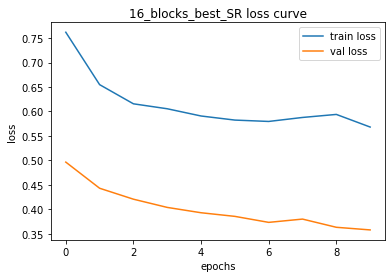

In [14]:
plt.title(f"{experiment_name} loss curve")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(loss_history["train"], label="train loss")
plt.plot(loss_history["val"], label="val loss")

plt.legend()
plt.savefig(f"{output_dir}/{experiment_name}_loss_curve.png")

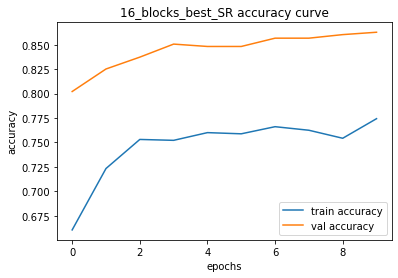

In [15]:
plt.title(f"{experiment_name} accuracy curve")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.plot(acc_history["train"], label="train accuracy")
plt.plot(acc_history["val"], label="val accuracy")

plt.legend()
plt.savefig(f"{output_dir}/{experiment_name}_acc_curve.png")

In [16]:
with open(f"{output_dir}/{experiment_name}_testloss={test_loss:.3f}_testacc={test_acc:.3f}.csv",'w') as outfile:
    print("train loss,val loss,train acc,val acc", file=outfile)
    for i in range(num_epochs):
        print(f"{loss_history['train'][i]},{loss_history['val'][i]},{acc_history['train'][i]},{acc_history['val'][i]}", file=outfile)
    

In [17]:
torch.save(model_ft, f"{output_dir}/{experiment_name}_best.pt")